#Clustering and Unsupervised Analysis

##Clustering Overview
<p>This notebook covers different clustering methods. We'll cover both k-means and hierarchical based clustering. We'll also cover how to incorporate SVD into clustering methods. <br><br>

Clustering is an unsupervised technique that doesn't require a particular outcome variable. The core idea of clustering follows this logic:<br>
<ul>
    <li>Identify an object/instance $i$ by its feature vector $X_i=<X_i^1,X_i^2,...,X_m^1>$ </li>
    <li>Define a distance function $d(X_i,X_j)$ to measure distance between $X_i$ and $X_j$.</li>
    <li>Create distinct groupings of instances that:</li>
    <ul>
        <li>Minimize intra-group distances</li>
        <li>Maximize inter-group distances</li>
    </ul>
</ul>
<br>
Note that in the above, if we use a similarity function instead of traditional distance metric (i.e., cosine similarity as opposed to Euclidean distance), we want to maximize similarity within clusters.
<br><br>
The key questions we often consider when clustering are:
<ul>
    <li>What is a good distance/similarity function?</li>
    <li>How many clusters is appropriate?</li>
    <li>How do we interpret/assess the clustering?</li>
</ul>
<br>
We'll explore these in the options below.

<br><br>
The data we'll use is from the student survey that everyone filled out at the beggining of the class. The survey asked for each student to rank themselves on a scale of 1 to 10 in each of the following DS related skill sets - Visualization, Computer Science, Math, Statistics, Machine Learning, Business, Communication. In the next section we load and do some basic distributions of the results.
</p>

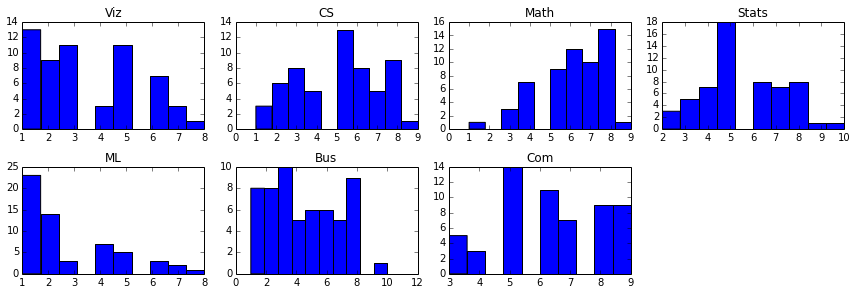

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

d = pd.read_csv('/Users/briand/Desktop/ds course/datasets/survey_2015.csv', header = 0, index_col = 0)
dpro = d[['profile_{}'.format(k+1) for k in range(7)]]
dpro.columns = ['Viz', 'CS', 'Math', 'Stats', 'ML', 'Bus', 'Com']

fig=plt.figure(figsize = (12, 6))
for i in range(7):
    plt.subplot(3, 4, i+1)
    plt.hist(dpro[dpro.columns.values[i]])
    plt.title(dpro.columns.values[i])

fig.tight_layout()

<p>We can see that most categories have a full range of values. An important question is how correlated are the values to each other. We'll explore this question in two different ways.<br><br>

First let's look at the correlation of the different categories.
</p>

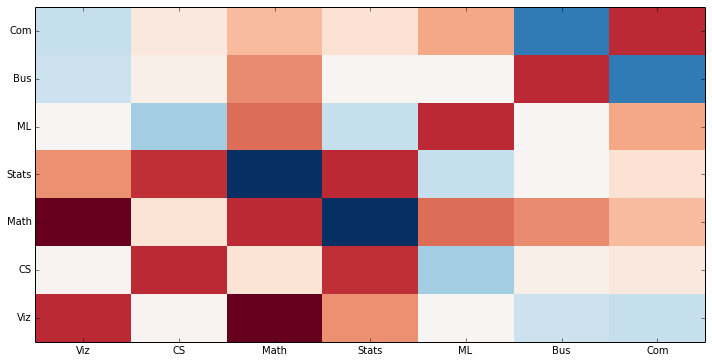

In [2]:

#Get correlation and 0 out the diagonal (for plotting purposes)
c_mat = dpro.corr()
for i in range(c_mat.shape[0]):
    c_mat.iloc[i, i] = 0

fig, ax = plt.subplots(figsize = (12, 6))
heatmap = ax.pcolor(c_mat, cmap=plt.cm.RdBu)

#Set the tick labels and center them
ax.set_xticks(np.arange(c_mat.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(c_mat.shape[1]) + 0.5, minor=False)
ax.set_xticklabels(c_mat.index.values, minor=False)
ax.set_yticklabels(c_mat.index.values, minor=False)

#heatmap.set_label('Pearson Correlation')

#plt.legend()

<p>We can see a range of correlations, while we also see two sets of strongly correlated features. These relationships are between "business/communication" and "math/stats." It is perhaps not surprising that students that rank themselves on one aspect of each of these sets might rank themselves highly on the other. We can also see that these two groups of correlated features are uncorrelated with each other. From this we can certainly sense that distinct segments of the student population might be exist.
<br><br>

##Latent Variables

With this range of correlation in the data, we might wonder whether certain latent features might exist that can explain the above observations. A latent feature (or variable) is described by  <a href="http://en.wikipedia.org/wiki/Latent_variable">Wikipedia</a> as: "...latent variables (or hidden variables, as opposed to observable variables), are variables that are not directly observed but are rather inferred (through a mathematical model) from other variables that are observed (directly measured). As we see above, students rank themselves very similarly in "math" and "stats". Both "math" and "stats" are the observed feature. The latent feature might be some sort of intellectual capacity for abstraction and logic. This hidden feature is of course manifested, and thus observed, in the form of skill in two related academic disciplines. <br><br>

One way to detect and define the latent features is through a decomposition of the observed features. Our student survey results are stored in a matrix $X$. Ideally, latent features will all be independent, and each observed feature might be a linear combination of the latent features. One straightfoward mechanism to to mathematically arrive at the properties just described is via the singular value decomposition. Here is a <a href="http://nbviewer.ipython.org/github/briandalessandro/DataScienceCourse/blob/master/ipython/Lecture3_PhotoSVD.ipynb">review</a> of the SVD and an example of a potential use case.<br><br>
For our exploratory analysis of the survey data, we'll use the SVD to define independent features (basically, latent features).<br><br>
This starts with the basic decomposition. We'll also generate a scree plot to get a sense of how important the various latent features are to the overall distribution of the data.


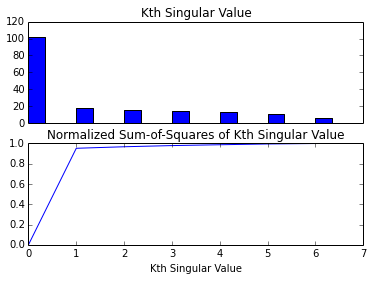

In [3]:
import course_utils as bd
reload(bd)
U, sig, Vt = np.linalg.svd(dpro, full_matrices=0)
bd.plotSVD(sig)

<p>This is a fairly extreme outcome. Most of the data can be explained by the first singular vector and value. We can guess that this first (and very dominant) latent feature might be related to having self-reported business/communication skills or math/stats skills. Remember from the above correlations, that this is almost an either/or scenario.<br><br>
So while we have good evidence that skills based segments exist, we have no principled way to identify them right now. Fortunately, there are tools to solve this problem.
</p>


##Clustering Examples
<p><a href="http://scikit-learn.org/stable/modules/clustering.html">Clustering</a> can be performed using the <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster">sklearn.cluster</a> library. We'll show two examples below, one using <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans">sklearn.cluster.kmeans</a> for K-Means clustering, and one using <a href="http://docs.scipy.org/doc/scipy-0.14.0/reference/cluster.hierarchy.html">scipy.cluster.hierarchy</a> for hierarchical clustering. Note, in the latter case we'll demo scipy not sklearn here because scipy supports plotting the cluster dendrograms better.


</p>


###K-means clustering
<p>
One decision we have to make is what data to use. We have our original feature matrix $X$, but we have also computed the SVD of $X$, which gives us an orthonormal matrix of user latent features $U$. If we use $U$, the features are normalized and independent. The normalization is important because clustering methods use distance metrics that are sensitive to scale. The indepedence means each feature will hold equal weight in the clustering. This may or may not be a good thing. For example, if we use $U$, we know that the fist singular vector is by far the most important. We might want this feature to dominate the clustering process. The good news is, we can weight the columns in $U$ using the singular values, i.e., cluster on $U\Sigma$ instead of $U$.<br><br>
A subtle corollary of this last point is using $U$ or $U\Sigma$ gives us a great tool to overcome the curse of dimensionality. If $X$ happend to be very high dimensional, but most of the sum-of-squares can be explained by a smaller first-$k$ subset of the singular vectors, then we might be better off clustering on $U_k$ or $U_k\Sigma_k$ (the rank-$k$ approximations). 
<br><br>
We start with a basic clustering. It is fairly easy to implement. In general, you'll always get a result, and a major question is always how do you know if it is a good fit? Ultimately, this becomes both a qualitative and quantitative issue. Some criteria might be:<br>
<ul>
    <li>Do the clusters make sense? (this is decidedly qualitative)</li>
    <li>Are the clusters well balanced? (a quantitative attribution to a potentially arbitrary need).</li>
</ul><br>
A similar question on quality, is what is the optimal $k$. For choosing $k$, we think of the above two questions, but we can also see how well the clusters minimize the within cluster sum of squares. This criteria is also called 'inertia' and is defined as:<br><br>

<center>$inertia = \sum\limits_{j=1}^k\:\sum\limits_{x_i \in C_j}|x_i-\mu_j|^2$
</center>



</p>

In [4]:
from sklearn import cluster

#Note - most of these input parms, except the first, help ensure stability of the fit
km = cluster.KMeans(n_clusters=2, init = 'k-means++', n_init = 5)
km.fit(dpro)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=5,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

<p>Let's loop through different values of k to get the inertia as a function of k. We'll also compute another metric that has been used to evaluate clusters where true cluster labels are not known (which is usually the case). This is called the Silhoette Coefficient. More details can be found <a href="http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation">here</a></p>

/Users/briand/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


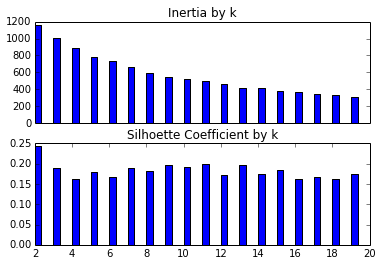

In [5]:
from sklearn.metrics import pairwise_distances
from sklearn import metrics

inert_k = []
sil_k = []

for k in range(2,20):
    km = cluster.KMeans(n_clusters=k, init = 'k-means++', n_init = 5)
    km.fit(dpro)
    inert_k.append(km.inertia_)
    sil_k.append(metrics.silhouette_score(dpro, km.labels_, metric='euclidean'))    

fix = plt.figure()
ax1 = plt.subplot(211)
plt.bar(range(2,20), inert_k, 0.35)
plt.title('Inertia by k')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
ax1 = plt.subplot(212)
plt.bar(range(2,20), sil_k, 0.35)
plt.title('Silhoette Coefficient by k')

<p>We can see that increasing $k$ tends to continually decrease the inertia. But at the same time, our Silhouette Coefficient does not increase. We should always expect inertia to decrease as $k$ increases, but the other metric shows that this does not exactly result in good clusters.
<br><br>
One method for determining a good value of $k$ is called the <a href="http://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method">elbow method</a>. This amounts to looking at the first plot above, and determining at what $k$ the within cluster sum of squares starts to level off. This is somewhat subjective, but tends to be useful.
</p>

<p>Next we'll look at a qualitative evaluation. For a small range of $k$, we first look at the distribution of clusters.
</p>

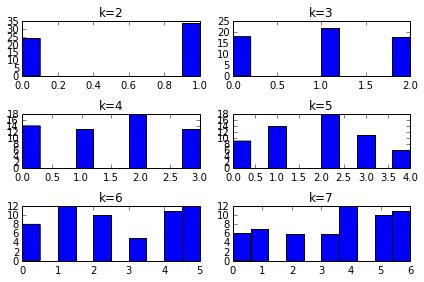

In [6]:
fig = plt.figure()
for k in range(2,8):
    km = cluster.KMeans(n_clusters=k, init = 'k-means++', n_init = 5)
    km.fit(dpro)
    ax = fig.add_subplot(3, 2 , k-1)
    plt.hist(km.labels_)
    plt.title('k={}'.format(k))

fig.tight_layout()

<p>We can see that the clusters are actually pretty well balanced for all values of $k$. Each choice of $k$ certainly has a clear maximum, but the differences aren't too extreme.<br><br>
The next thing we might try to do then is define the clusters based on the centroids. The centroid essentially describes the average student within each cluster. We can use that to better understand and then define the clusters. For comparison's sake, we'll also show this for clusters derived using $U$ and $U\Sigma$. When doing this though, we have to remember to report the cluster means in the original $X$ space for us to be able to interpret it. To project the $U\Sigma$ centroids back into the $X$ space, we just right multiply the centroid by $V^T$ from the SVD.<br><br>
Another thing we do here is we subtract the mean of $X$ from each centroid. This is because we're more interested in how each cluster differs from the average student profile.
</p>

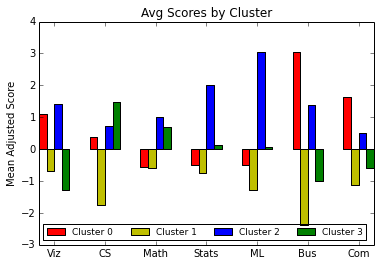

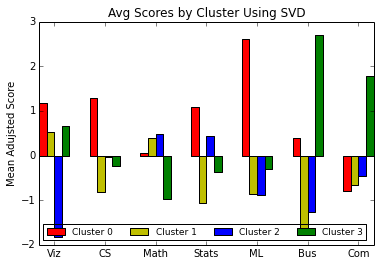

In [15]:
#Clustering on original X space
km = cluster.KMeans(n_clusters=4, init = 'k-means++', n_init = 10)
km.fit(dpro)
cols = ['r','y','b','g']

fig = plt.figure()
for i, cc in enumerate(km.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    plt.bar(np.arange(len(cc)) + i*w, cc - dpro.mean(), w, 
            color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Avg Scores by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9})
   
#Now cluster on the SVD space
km_u = cluster.KMeans(n_clusters=4, init = 'k-means++', n_init = 10)
#km_u.fit(pd.DataFrame(U.dot(diag(sig))))
km_u.fit(pd.DataFrame(U))
cols = ['r','y','b','g']

fig = plt.figure()
for i, cc in enumerate(km_u.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    #plt.bar(np.arange(len(cc))+i*w, cc.dot(Vt), w, color = cols[i], label='Cluster {}'.format(i))
    plt.bar(np.arange(len(cc)) + i*w, cc.dot(np.diag(sig).dot(Vt)) - dpro.mean(), 
            w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adujsted Score')
plt.title('Avg Scores by Cluster Using SVD')
plt.legend(loc = 3, ncol = 4, prop={'size':9})

<p>In the above we chose $k=4$. Let's assume we did this because we want to assign students to groups of 4 to work together in a study group. Our goal would be to maximize the skill diversity of each group, so we'd cluster into 4 clusters and assign one student per cluster into each group. If we look at the above plots, we can get a sense of how the average person within each group differs from the average student in the class. When we make our profiles, we'll use the bottom chart, as the clusters using $U\Sigma$ seem to be more pronounced.
<br><br>
<b><u>Student Profiles</u></b>
<ul>
    <li><u>Cluster 0</u> doesn't have any defining strong properties and tend to be consistent with the average student profile. They do tend to be the strongest at math and machine learning though.</li>
    <li><u>Cluster 1</u> looks like our best stats group.</li>
    <li><u>Cluster 2</u> looks like our CS students. These the strong programmers in the group.</li>
    <li><u>Cluster 3</u> are the business and strategy minded students. </li>
</ul>
</p>

###Hierarchical Clustering
<p>
In the above we showed how to compute and evaluate K-Means, and we also came up with a use case for the clustering. The above use case (i.e., putting students into study groups of size 4) essentially dictated the choice of $k$. In a more general use case, we might not have such an application specific best $k$. One way we can be more general is to use hiearchical clustering. In this type of clustering, the individual clusters are embedded in a taxonomy. We can use this taxonomy to see if there are any natural values of $k$ that make the most sense. We can also use it to ensure that each final cluster we choose is well balanced in size. Additionally, we can use this to get a sense of any outlier clusters (those with very small counts).<br><br>

Using Scipy isn't as straightforward as using Sklearn, but again, scipy has a good procedure for displaying the dendrogram.

</p>

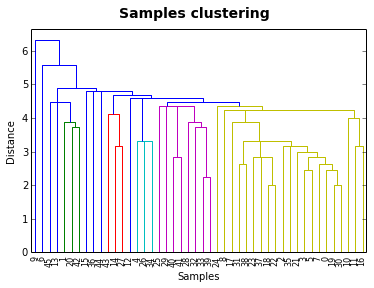

In [16]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import cluster
import pandas as pd

d = pd.read_csv('/Users/briand/Desktop/ds course/datasets/survey.csv',header=0,index_col=0)
dpro = d[['profile_{}'.format(k+1) for k in range(7)]]
dpro.columns = ['Viz','CS','Math','Stats','ML','Bus','Com']


#This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(dpro)

#This function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists)

p = 46
#Now we want to plot the dendrogram
den = dendrogram(links, truncate_mode = 'lastp', p = p)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);


<p>Let's try to understand the output of the linkage function. The first few records look like:
</p>

In [17]:
links[:5,:]

array([[ 19.        ,  30.        ,   2.        ,   2.        ],
       [ 18.        ,  22.        ,   2.        ,   2.        ],
       [ 33.        ,  39.        ,   2.23606798,   2.        ],
       [  3.        ,   5.        ,   2.44948974,   2.        ],
       [  0.        ,  46.        ,   2.44948974,   3.        ]])

<p>The way we read this is as follows:
<ul>
    <li>At the lowest level, each record is assigned to its own cluster, and the cluster number is just its original index.</li>
    <li>The linkage function returns an (n-1) by 4 matrix where:</li>
        <ul>
            <li>The ith row corresponds to a new cluster, whose id=n+i</li>
            <li>The L[i,0] and L[i,1] columns are the two clusters that are joined to make cluster (n+i)</li>
            <li>The column L[i, 2] is the distance between L[i,0] and L[i,1]</li>
            <li>The last column is the final size of cluster (n+i)</li>
        </ul>
</ul><br>
In the above few rows, we see that user 19 and 30 were combined to make cluster 46. Then, we see in the 5th row that this cluster 46 was joined with user 0 to make cluster 50. If we look up at the dendrogram we can see these 3 students being combined into a single cluster.

</p>

In [191]:
#Note code to follow

<p>If we want to use a hiearchical clustering technique to get a specific number of clusters, we can use <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.Ward.html#sklearn.cluster.Ward">sklearn.cluster.Ward</a> for a concise process that returns exactly what we need.  We'll continue with our student study group example and choose $k=4$.


</p>

In [18]:
ka = cluster.Ward(n_clusters = 4)
ka.fit(dpro)

Ward(compute_full_tree='auto', connectivity=None, copy=True,
   memory=Memory(cachedir=None), n_clusters=4, n_components=None)

<p>Let's do another plot of mean adjusted centroids to get a sense of what each cluster represents. Sklearn.cluster.Ward does not return the centroids, so we'll have to compute this step ourselves.
</p>

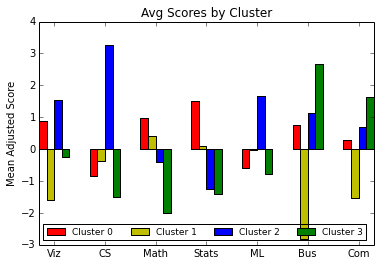

In [19]:
#Clustering on original X space using Hierarchical clustering

cols = ['r','y','b','g']

fig = plt.figure()
for i in range(4):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    cc = dpro[(ka.labels_==i)].mean()
    plt.bar(np.arange(len(cc))+i*w, cc - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Avg Scores by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9})
   

<p>When we plot the 4 clusters using hierarchical clustering, we get similar conceptual groupings as we did with k-means. However, I find this latter plot more easy to interpret (remember, this is a bit subjective).
<br><br>
<b><u>Student Profiles using Hierarchical Clustering</u></b>
<ul>
    <li><u>Cluster 0:</u> This group has most of the math/stats experience</li>
    <li><u>Cluster 1:</u> This group is a little below average in skill across all categories (or at least is the group that underrates their own skill levels).</li>
    <li><u>Cluster 2:</u> These are the strong programmers in the group.</li>
    <li><u>Cluster 3:</u> These are the business and strategy minded students. </li>
</ul>
<br><br>
So now we have to make a choice - which clustering method to use for the student profiles. One last thing to compare is the distribution of students across clusters for each method.
</p>

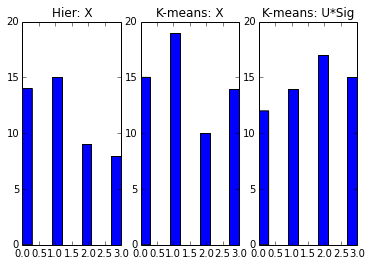

In [20]:

plt.subplot(1,3,1)
plt.hist(ka.labels_)
plt.ylim([0,20])
plt.title('Hier: X')

plt.subplot(1,3,2)
plt.hist(km.labels_)
plt.ylim([0,20])
plt.title('K-means: X')

plt.subplot(1,3,3)
plt.hist(km_u.labels_)
plt.ylim([0,20])
plt.title('K-means: U*Sig')

fig.tight_layout()


<p>Comparing the above methods, we see that (objectively), hierarchical based clustering gives more even clusters, and that in our subject opinion, the results are easier to interpret. Given these properties, for a final analysis, we would go with hierarchical clustering for the application of putting students into study groups of size 4. 
</p>